<a href="https://colab.research.google.com/github/ebubelk/Cure_The_Princess_MLP/blob/main/Cure_The_Princess_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda":
  print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
else:
  print("GPU is enabled in this notebook.")

In [4]:
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
SEED = 190401072
set_seed(seed=SEED)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.targets = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.Tensor(self.data[index])
        y = torch.Tensor([self.targets[index]])
        return x, y

trainset = CustomDataset(pd.read_csv('/content/cure_the_princess_train.csv'))
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

valset = CustomDataset(pd.read_csv('/content/cure_the_princess_validation.csv'))
valloader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=2)

testset = CustomDataset(pd.read_csv('/content/cure_the_princess_test.csv'))
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

test_data = pd.read_csv('/content/cure_the_princess_test.csv')
test_value = test_data['Cured'].values

In [7]:
class MLP(nn.Module):
    def __init__(self):
        set_seed(seed=SEED)
        super(MLP, self).__init__()
        self.hidden_layer_first = nn.Linear(13, 100)
        self.hidden_layer_second = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, 1)
        self.relu = nn.ReLU() # ReLU aktivasyonu
        self.sigmoid = nn.Sigmoid() # sigmoid aktivasyonu
        self.dropout_first = nn.Dropout(0.3)
        self.dropout_second = nn.Dropout(0.2)
        
    def forward(self, x):
        #Add Dropout
        x = self.dropout_first(self.relu(self.hidden_layer_first(x)))
        x = self.dropout_second(self.relu(self.hidden_layer_second(x)))
        x = self.sigmoid(self.output_layer(x))
        return x

Epoch 0 Training loss 0.7870837653739543 Validation Loss : 0.657361975312233
Epoch 1 Training loss 0.7185468315323696 Validation Loss : 0.6210294306278229
Epoch 2 Training loss 0.672080432312398 Validation Loss : 0.5999714493751526
Epoch 3 Training loss 0.6423212493522258 Validation Loss : 0.5820722877979279
Epoch 4 Training loss 0.6541355735139002 Validation Loss : 0.5660208374261856
Epoch 5 Training loss 0.6378436043292661 Validation Loss : 0.5518316447734832
Epoch 6 Training loss 0.6064341849164118 Validation Loss : 0.5366196990013122
Epoch 7 Training loss 0.5869980888276161 Validation Loss : 0.515430448949337
Epoch 8 Training loss 0.5929133703437033 Validation Loss : 0.5001597076654434
Epoch 9 Training loss 0.5775475271894962 Validation Loss : 0.48908049911260604
Epoch 10 Training loss 0.5718503311465059 Validation Loss : 0.4677301675081253
Epoch 11 Training loss 0.5581067155433607 Validation Loss : 0.45666633248329164
Epoch 12 Training loss 0.5642498897600777 Validation Loss : 0.4

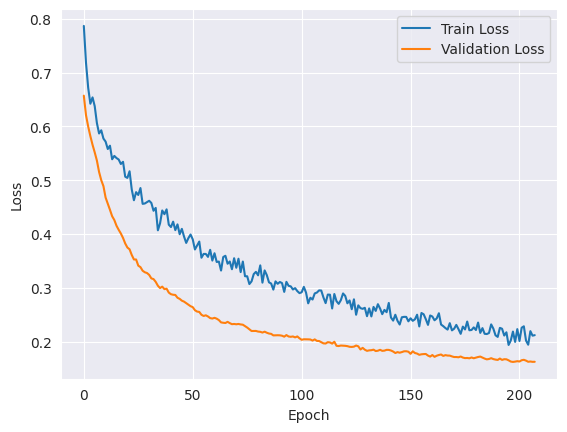

Run time: 103.48799443244934


In [12]:
start = time.time()
# Egitim parametreleri
learning_rate = 0.001
num_epochs = 1000
patience = 10
weight_decay = 0.001

# Model, loss fonksiyonu ve optimizer olusturma
model = MLP()
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

# Egitim donguss
list_train_loss = []
list_val_loss = []
best_val_loss = None
patience_counter = 0

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train() # train modunda modeli ayarla
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(trainloader)
    
    # Dogrulama seti uzerinde modelin performansini degerlendirme
    val_loss = 0.0
    model.eval() # eval modunda modeli ayarla
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(valloader)
    
    print("Epoch", epoch, "Training loss", train_loss, "Validation Loss :", val_loss)
    
    list_train_loss.append(train_loss)
    list_val_loss.append(val_loss)
    
    val_score = val_loss
    if best_val_loss is None:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score:  # patience counter
        patience_counter += 1
        print("Earlystopping Patience Counter:", patience_counter)
        if patience_counter == patience:
            print("Early stopping triggered.")
            break
    else:
        best_val_loss = val_score  # En iyi loss'u guncelle
        patience_counter = 0  # patience counter'i sifirla
torch.save(model.state_dict(), "last.pt")

sns.set_style("darkgrid")
plt.plot(list_train_loss, label="Train Loss")
plt.plot(list_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
end = time.time()
print("Run time:", end - start)

In [10]:
device = "cpu"
model.to(device)
model.load_state_dict(torch.load("last.pt"))
model.eval()
test_loss = 0.0
outputs_list = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        outputs = (outputs >= 0.5).float()
        outputs_list.append(outputs)
test_loss /= len(testloader)
outputs_list = torch.cat(outputs_list, dim=0).numpy()
test_acc = accuracy_score(test_value, outputs_list)
test_f1 = f1_score(test_value, outputs_list, average='weighted')
test_precision = precision_score(test_value, outputs_list)
test_recall = recall_score(test_value, outputs_list)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test F1 Score:", test_f1)
print("Test Precision Score:", test_precision)
print("Test Recall Score:", test_recall)


Test Loss: 0.1680730119043467
Test Accuracy: 0.9352331606217616
Test F1 Score: 0.9351600623159575
Test Precision Score: 0.9694444444444444
Test Recall Score: 0.8994845360824743
